# Defasagem Espacial Sul

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/defasagem_espacial_sul.ipynb`

## Bibliotecas

In [1]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 14.4MB/s 
     |████████████████████████████████| 14.7MB 308kB/s 
     |████████████████████████████████| 225kB 2.8MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=67249dec810ac6f50f01d77900e593c4ef41c66f28d69175b0d945ef02ec7e9d
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp
Requirement already up-to-date: descartes in /usr/local/lib/python3.6/dist-packages (1.1.0)
     |████████████████████████████████| 2.4MB 6.0MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 266kB 33.1MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 235kB 28.6MB/s 
  Created wheel for libpysal: filename=libpysal-4.3.0-py2.py3-none-any.whl size=2379082 sha256=5356305a730075636b0c2d32355fba1b9a

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
dados_br = cod_dados.merge(seguro, how='left')

In [19]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

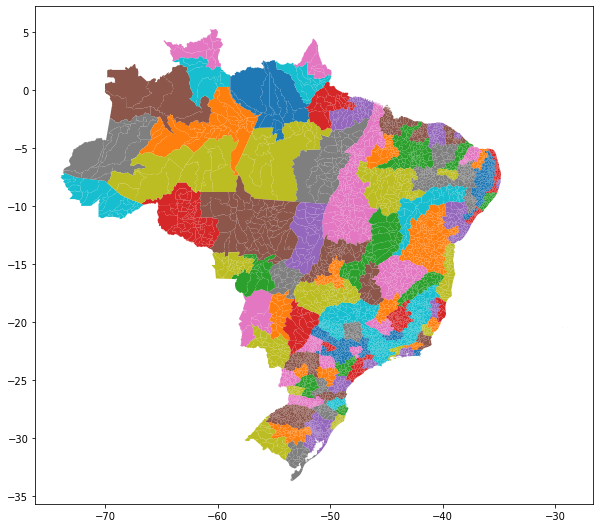

In [20]:
dados_br.plot(column='nome_meso', figsize=(10, 10), k=4); # , cmap='OrRd',  cmap='plasma'

## Sul

In [21]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

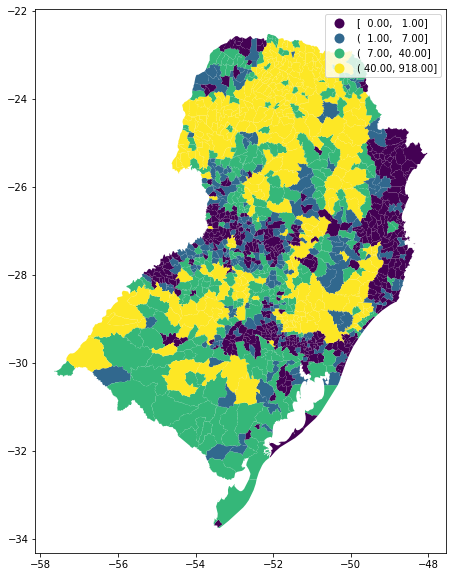

In [22]:
dados_sul.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', legend=True, k=4); # , cmap='OrRd'

## Defasagem espacial - Sul

In [23]:
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [24]:
dados_sul.columns

Index(['Unnamed: 0', 'uf', 'nome_uf', 'mun', 'nome_mun', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'codmun6', 'regiao', 'nome_regiao',
       'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [25]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'Unnamed: 0', 'rm'] # , 'geometry'
dados_lag = dados_sul.drop(retirar, axis = 1)

In [26]:
dados_lag.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [27]:
for variavel in dados_lag.drop(['nome_mun', 'geometry'], axis = 1).columns:
    dados_lag[variavel+'_lag'] = weights.spatial_lag.lag_spatial(w, dados_lag[variavel])

In [28]:
dados_lag = dados_lag.set_index('nome_mun')

In [29]:
dados_lag.head()

,geometry,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
nome_mun,,,,,,,,,,,,,,,,,
abatia,"POLYGON ((-50.22465 -23.22603, -50.22482 -23.2...",40.0,3543216.22,304971.61,134087.83,587718.37,21649.66,1141.40,26.0,122.000000,1.832898e+07,1.388129e+06,607043.117500,2.597552e+06,51319.365,1944.255000,57.5
adrianopolis,"POLYGON ((-48.99969 -24.63712, -49.00943 -24.6...",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.333333,1.978600e+06,3.778476e+04,14003.636667,0.000000e+00,0.000,29.666667,0.0
agudos_do_sul,"POLYGON ((-49.30433 -25.94769, -49.29320 -25.9...",2.0,446126.98,51446.03,23150.71,20487.60,924.00,0.23,1.0,3.000000,1.672307e+05,9.925758e+03,4227.454000,0.000000e+00,0.000,106.800000,0.0
almirante_tamandare,"POLYGON ((-49.28261 -25.22827, -49.25086 -25.2...",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000,0.000000,0.0
altamira_do_parana,"POLYGON ((-52.81511 -24.71726, -52.79698 -24.7...",4.0,892341.25,53858.49,24236.32,0.00,0.00,233.00,0.0,69.600000,9.287946e+06,6.862113e+05,297705.336000,5.414249e+05,18662.156,1152.424000,13.8


## Análise de agrupamento - Defasagem espacial - Sul

In [30]:
# subselecionar variáveis
X = dados_lag.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [31]:
Z = linkage(X, method='ward')

In [32]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

In [33]:
import sys
print(sys.getrecursionlimit())
# sys.setrecursionlimit(2000)

1000


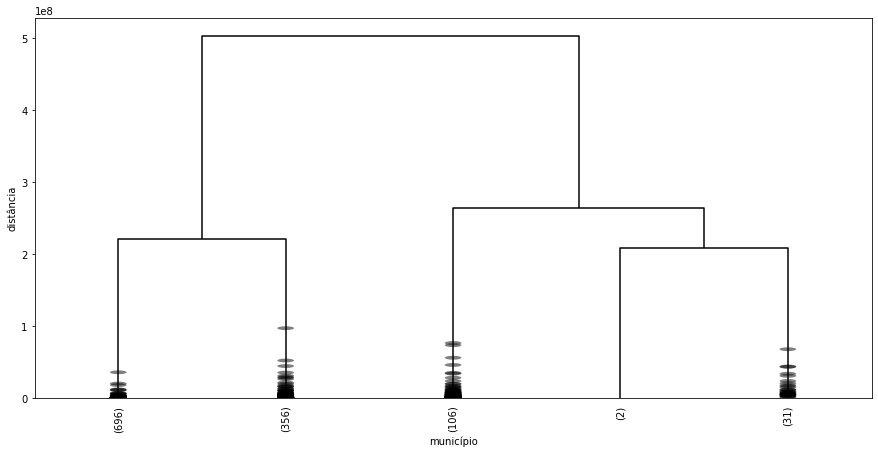

In [34]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [35]:
Z = linkage(X, method='ward')

In [36]:
# definir a distância de corte baseando no dendrograma
max_d = 2e8
grupos = cut_tree(Z, height=max_d)

### Métricas

In [37]:
dados_metrics = dados_lag.drop('geometry', axis=1)

In [38]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics.values, grupos.ravel(), metric='euclidean'),2)  
)

1095.83 0.81 0.54


In [39]:
  # incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_lag['grupo'] = grupos
# moran_matrix.head(2)

In [40]:
# contagem de observações em cada grupo
dados_lag.grupo.value_counts()

1    696
0    356
2    106
3     31
4      2
Name: grupo, dtype: int64

In [41]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lag.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
grupo,,,,,,,,,,,,,,,,
0,42.289326,6.212519e+06,4.569387e+05,1.975246e+05,4.234297e+05,11762.264719,835.850056,11.449438,62.454479,9.881027e+06,7.457084e+05,3.219505e+05,6.629265e+05,14694.709366,975.601939,16.987142
1,5.241379,6.688775e+05,4.522732e+04,1.928072e+04,3.743902e+04,1690.346853,139.036954,1.087644,9.334069,1.377736e+06,9.624533e+04,4.108382e+04,6.830384e+04,2471.731279,201.474221,1.894487
2,139.103774,1.942967e+07,1.494038e+06,6.547700e+05,1.929588e+06,29060.521321,1678.293868,47.481132,160.289022,2.340972e+07,1.980293e+06,8.645778e+05,2.400668e+06,28211.236738,1643.773343,58.405836
3,327.580645,4.996883e+07,3.834037e+06,1.654511e+06,5.775099e+06,44596.725484,2321.275161,129.935484,160.964657,2.183070e+07,1.731564e+06,7.586992e+05,2.474536e+06,26277.128607,1549.734120,60.363082
4,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,100.928571,2.295724e+07,2.401718e+06,1.013775e+06,2.016052e+06,16310.326429,968.210714,39.285714


In [42]:
# mediana das variáveis para cada grupo
dados_lag.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
grupo,,,,,,,,,,,,,,,,
0,32.0,5.408844e+06,373384.59,161433.290,122669.945,5553.500,642.135,4.0,51.000000,8.668625e+06,6.522499e+05,2.812286e+05,3.502940e+05,8892.596667,774.047500,8.225000
1,1.0,7.525230e+04,5454.90,2395.335,0.000,0.000,54.000,0.0,5.200000,7.695774e+05,4.551051e+04,1.927279e+04,1.341749e+04,812.800000,125.948571,0.500000
2,125.0,1.960085e+07,1389856.13,609930.330,1228814.785,30974.115,1672.335,29.5,163.196429,2.149121e+07,1.733527e+06,7.588783e+05,1.788691e+06,33984.543125,1802.291750,50.071429
3,301.0,4.565170e+07,3644003.60,1569998.820,3971779.190,45365.860,2125.450,93.0,128.625000,1.815201e+07,1.426695e+06,6.143044e+05,1.500269e+06,25787.520000,1601.232857,47.200000
4,487.0,1.557418e+08,21566742.09,9364997.510,2660478.720,12995.410,2057.350,57.0,100.928571,2.295724e+07,2.401718e+06,1.013775e+06,2.016052e+06,16310.326429,968.210714,39.285714


### As observações de cada grupo


In [43]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com defasagem espacial

In [44]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

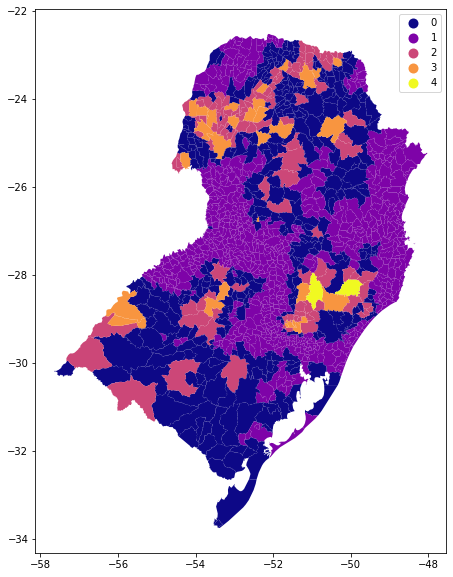

In [45]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, k=4, cmap = 'plasma'); # , cmap='OrRd'

## K-Médias - Defasagem espacial


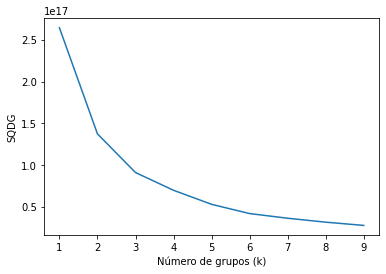

In [46]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_lag.drop('geometry', axis=1))
    dados_lag['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [58]:
k = 4

In [59]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [60]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

1097.93 0.72 0.63


In [61]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_lag['grupo'] = kmeans.labels_

In [62]:
# contagens
dados_lag.grupo.value_counts()

0    907
2    242
1     40
3      2
Name: grupo, dtype: int64

In [63]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [64]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lag.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag,grupos
grupo,,,,,,,,,,,,,,,,,
0,11.012128,1.524399e+06,1.079790e+05,4.625038e+04,9.165244e+04,3266.862712,255.701577,2.532525,18.151090,2.749171e+06,1.988514e+05,8.561697e+04,1.507077e+05,4281.986769,334.068221,4.119434,2.242558
1,312.825000,4.528827e+07,3.492846e+06,1.512781e+06,5.873323e+06,45861.241250,2281.550750,132.200000,180.063581,2.548117e+07,2.095936e+06,9.142556e+05,3.147024e+06,27948.660281,1651.949410,74.233611,2.450000
2,87.198347,1.277526e+07,9.657885e+05,4.213770e+05,1.001245e+06,20782.096157,1326.477934,26.070248,111.757296,1.703300e+07,1.371293e+06,5.956562e+05,1.455165e+06,23780.641217,1408.033999,36.043756,4.648760
3,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,100.928571,2.295724e+07,2.401718e+06,1.013775e+06,2.016052e+06,16310.326429,968.210714,39.285714,3.000000


In [65]:
# mediana das variáveis para cada grupo
dados_lag.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag,grupos
grupo,,,,,,,,,,,,,,,,,
0,3.0,2.898500e+05,1.980917e+04,8640.460,0.000,0.000,98.000,0.0,9.000000,1.460046e+06,8.975586e+04,3.694578e+04,3.311311e+04,1530.000000,205.000000,1.000000,0
1,299.5,4.261514e+07,3.293477e+06,1394123.685,4297834.915,45134.975,2081.260,93.0,152.142857,1.923606e+07,1.550260e+06,6.909586e+05,1.638069e+06,29327.652857,1777.392000,48.100000,1
2,70.5,1.177617e+07,8.932522e+05,378572.175,575014.505,15735.605,1203.325,16.0,90.050000,1.504619e+07,1.168167e+06,4.971288e+05,1.151758e+06,21426.567500,1296.423333,24.346154,6
3,487.0,1.557418e+08,2.156674e+07,9364997.510,2660478.720,12995.410,2057.350,57.0,100.928571,2.295724e+07,2.401718e+06,1.013775e+06,2.016052e+06,16310.326429,968.210714,39.285714,3


In [66]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com defasagem espacial

In [67]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

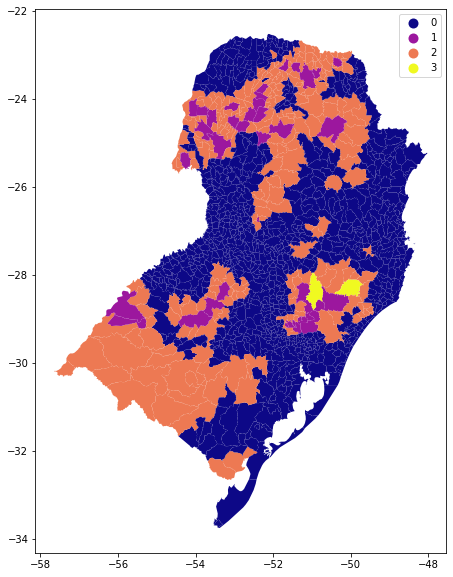

In [68]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, k=4, cmap = 'plasma'); # , cmap='OrRd'